### Global Variables

In [1]:
from sklearn.preprocessing import LabelEncoder

image_size = 96
num_samples = 5
epochs = 50
label_encoder = LabelEncoder()

### Image Functions

In [2]:
from typing import List, Tuple, Optional
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
from scipy.ndimage import rotate
import random
from sys import maxsize as max_int


# Function to load images and labels from a directory
def load_images(folder: str, n: Optional[int] = None) -> Tuple[List[np.ndarray], List[str]]:
    images = []
    labels = []
    label_folders = os.listdir(folder)
    for label_folder in tqdm(label_folders):
        count = 0
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            for img_file in glob(os.path.join(label_path, "*.jpg")):
                if n is not None and count >= n:
                    continue
                img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
                images.append(img)
                labels.append(label_folder)
                count += 1

    assert len(images) == len(labels), "Mismatch in number of images and labels"
    return images, labels


def display_samples(images: List[np.ndarray], labels: List[str]) -> None:
    # display some sample images with their labels
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        rand = np.random.randint(0, len(images))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[rand], cmap='gray')
        plt.title(f"{labels[rand]}")
        plt.axis('off')
    plt.show()

### Processing Functions

In [3]:
def downsample_image(image: np.ndarray) -> np.ndarray:
    # Downsample the image if its dimensions are larger than 1000
    max_dim = 1000
    if max(image.shape) > max_dim:
        scale = max_dim / max(image.shape)
        new_size = (int(image.shape[1] * scale), int(image.shape[0] * scale))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    return image


def detect_circles(image: np.ndarray, max = max_int, threshold = 100, show: bool = False) -> np.ndarray:
    circles = [[]]
    threshold = 100
    downsampled_image = downsample_image(image)
    blur = min(downsampled_image.shape) // 35
    blurred_image = cv2.blur(downsampled_image, (blur, blur))
    while True:
        circles = cv2.HoughCircles(
            blurred_image,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=20,
            param1=threshold,
            param2=threshold,
            minRadius=10,
            maxRadius=min(blurred_image.shape)
        )
        if circles is not None or threshold <= 5:
            break
        else:
            threshold -= 5
    
    circles = np.round(circles[0, :]).astype("int")

    if show:
        circle_image = image.copy()
        if circles is not None:
            for (x, y, r) in circles:
                cv2.circle(circle_image, (x, y), r, (0, 255, 0), 4)

        image_list = {
            "Original": image,
            "Blurred": blurred_image,
            "Detected Circles": circle_image
        }

        plt.figure(figsize=(20, 4))
        for i, (name, img) in enumerate(image_list.items()):
            plt.subplot(1, 3, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(name)
            plt.axis('off')

        plt.show()

    return circles[:max]


def crop_to_circle(img: np.ndarray, circles: np.ndarray) -> np.ndarray:
    cropped_imgs = []
    if circles is not None:
        for (x, y, r) in circles:
            cropped_img = img[y-r:y+r, x-r:x+r]
            cropped_imgs.append(cropped_img)
    return cropped_imgs


def remove_nones(images: List[np.ndarray], labels: List[str]) -> Tuple[np.ndarray, List[str]]:
    new_images = []
    new_labels = []
    if labels is None:
        labels = [None] * len(images)
    for img, label in zip(images, labels):
        if img is not None and min(img.shape) >= image_size:
            new_images.append(img)
            new_labels.append(label)
    return np.array(new_images), new_labels


def preprocess_images(images: List[np.ndarray], labels: List[str], max: int = max_int) -> Tuple[List[np.ndarray], List[str]]:
    cropped_images = []
    cropped_labels = []
    images_with_labels = list(zip(images, labels))
    for img, label in tqdm(images_with_labels):
        circles = detect_circles(img, max=max)
        cis = crop_to_circle(img, circles)
        cropped_images.extend(cis)
        cropped_labels.extend([label] * len(cis))

    processed_images, processed_labels = downsample_images(cropped_images, cropped_labels)
    return processed_images, processed_labels


def downsample_images(images: List[np.ndarray], labels: List[str] = None, size: int = image_size) -> Tuple[np.ndarray, List[str]]:
    downsampled_images = []
    for img in images:
        if img is None or min(img.shape) < size:
            downsampled_images.append(None)
        else:
            downsampled_images.append(cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA))
    
    downsampled_images, labels = remove_nones(downsampled_images, labels)
    return np.array(downsampled_images), labels


def circle_mask_images(images: List[np.ndarray]) -> np.ndarray:
    masked_images = []
    for image in images:
        # Get the dimensions of the image
        height, width = image.shape[:2]

        # Create a mask with a filled circle in the center
        mask = np.zeros((height, width), dtype=np.uint8)
        center = (width // 2, height // 2)
        radius = min(center[0], center[1], width - center[0], height - center[1])
        cv2.circle(mask, center, radius, 255, -1)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_images.append(masked_image)

    return np.array(masked_images)


def augment_image(image):
    # randomly rotate the image
    angle = random.uniform(-30, 30)
    rotated_image = rotate(image, angle, reshape=False)

    # randomly flip the image
    if random.choice([True, False]):
        flipped_image = np.fliplr(rotated_image)
    else:
        flipped_image = np.flipud(rotated_image)

    # pad to original size and return
    return flipped_image

### CNN Function

In [4]:
import keras
import keras.models
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


def train_model(input_x: np.ndarray, input_y: np.ndarray, shape: Tuple[int, int], epochs: int) -> Tuple[keras.Sequential, keras.callbacks.History]:
    input_x = np.array(input_x)
    
    # Convert string labels to numerical values
    input_y = label_encoder.fit_transform(input_y)
    class_weights = compute_class_weight('balanced', classes=np.unique(input_y), y=input_y)
    class_weights = dict(enumerate(class_weights))
    input_y = to_categorical(input_y)
    num_classes = input_y.shape[1]

    train_images, val_images, train_labels, val_labels = train_test_split(input_x, input_y, test_size=0.2, random_state=42)
    train_images = circle_mask_images(train_images)
    val_images = circle_mask_images(val_images)

    model = keras.Sequential()

    # convolutional layer 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(shape[0], shape[1], 1), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 3
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # flatten the output
    model.add(Flatten())

    # fully connected layer
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # output layer
    model.add(Dense(num_classes, activation='softmax'))

    # compile the model and print summary
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        # shear_range=0.2,
        # zoom_range=0.2,
        # horizontal_flip=True,
        fill_mode='nearest'
    )

    train_images = np.expand_dims(train_images, axis=-1)
    # Fit the generator to your training data
    datagen.fit(train_images)

    # train the model
    history = model.fit(
        train_images, train_labels,
        epochs=epochs,
        validation_data=(val_images, val_labels),
        class_weight=class_weights,
        callbacks=[EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)]
    )
    model.summary()
    return model, history

### Load Original Images

100%|██████████| 11/11 [00:02<00:00,  4.73it/s]


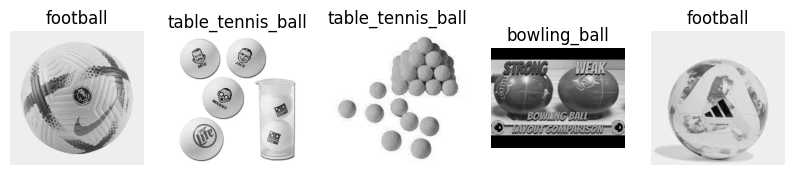

In [5]:
# Load images and labels from train and test folders
original_images, original_labels = load_images("data/train")
test_images, test_labels = load_images("data/test")

display_samples(original_images, original_labels)


### Circle Detection Example

Image 3086
(480, 480)


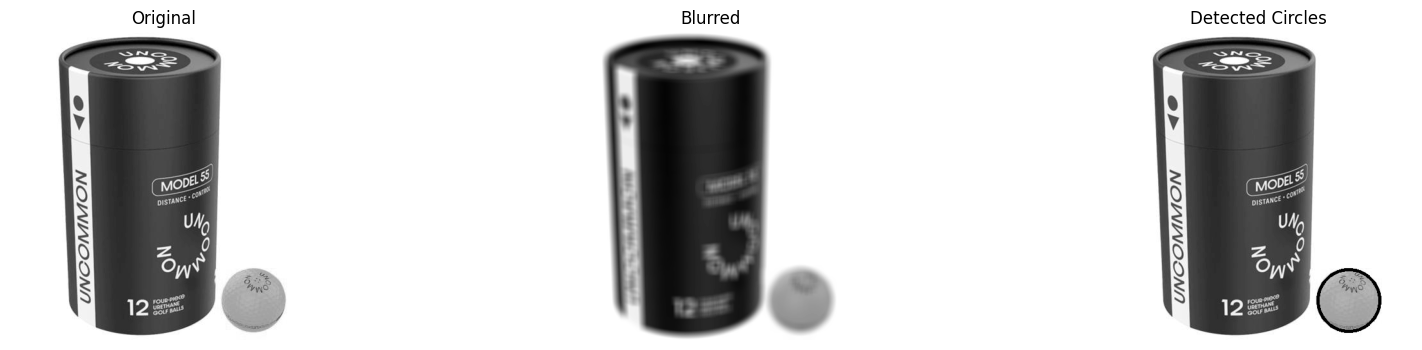

array([[380, 418,  48]])

In [6]:
rand = np.random.randint(len(original_images))
print(f"Image {rand}")
print(original_images[rand].shape)
detect_circles(original_images[rand], show=True)


### Preprocess images

- circles detected
- images cropped to circles
- images downsampled to _image_size_


In [7]:
processed_images, processed_labels = preprocess_images(original_images, original_labels)
display_samples(processed_images, processed_labels)

  5%|▌         | 294/5632 [00:12<03:54, 22.75it/s]


KeyboardInterrupt: 

### Load Training Images

- These images were previously processed and saved to disk
- images downsampled to _image_size_

100%|██████████| 11/11 [00:02<00:00,  5.50it/s]


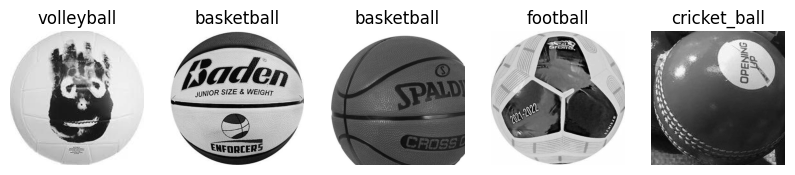

In [8]:
ball_images, ball_labels = load_images("data/ball")
downsampled_images, downsampled_labels = downsample_images(ball_images, ball_labels)
display_samples(ball_images, ball_labels)

### Diversify Images and mask them to circles

- Randomly rotate and flip the images

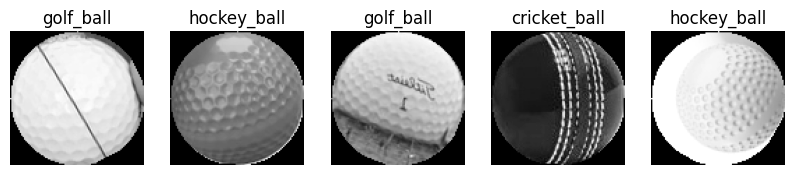

In [9]:
# diversify the images
diversified_images = [augment_image(image) for image in downsampled_images]
diversified_images = circle_mask_images(diversified_images)

encoded_labels = label_encoder.fit_transform(downsampled_labels)
encoded_labels = to_categorical(encoded_labels)
decoded_labels = label_encoder.inverse_transform(np.argmax(encoded_labels, axis=1))

display_samples(diversified_images, decoded_labels)

# combine the original and diversified images
all_images = np.concatenate((downsampled_images, diversified_images))
all_labels = np.concatenate((downsampled_labels, downsampled_labels))

### CNN

In [10]:
label_encoder.fit(ball_labels)
model, history = train_model(downsampled_images, downsampled_labels, downsampled_images[0].shape, epochs)
model.save("ball_cnn.keras")

c:\Users\jamie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.2134 - loss: 3.2675 - val_accuracy: 0.1987 - val_loss: 3.7325
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.3827 - loss: 2.5705 - val_accuracy: 0.2896 - val_loss: 3.0153
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.4761 - loss: 2.3681 - val_accuracy: 0.3350 - val_loss: 2.8986
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.5533 - loss: 2.1152 - val_accuracy: 0.2896 - val_loss: 3.0867
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.5728 - loss: 2.0461 - val_accuracy: 0.3923 - val_loss: 2.8365
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.6588 - loss: 1.9524 - val_accuracy: 0.4495 - val_loss: 2.5702
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.7053 - loss: 1.7803 - val_accuracy: 0.4832 - val_loss: 2.7205
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.7762 - loss: 1.6102 - val_accuracy: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,446,883 (55.11 MB)

 Trainable params: 4,815,307 (18.37 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 9,630,616 (36.74 MB)

### Application

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


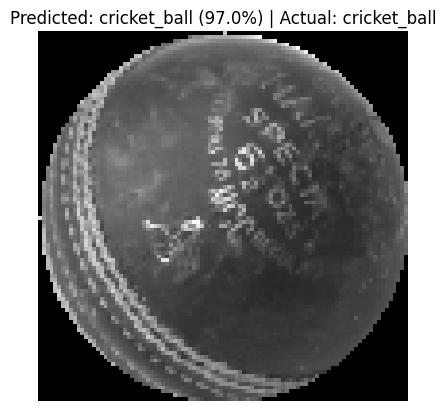

In [83]:
from keras.saving import load_model


def identify_ball(model: keras.Sequential, image: np.ndarray) -> Tuple[np.ndarray, str]:
    # Preprocess the image
    circles = detect_circles(image, show=False)
    cropped_images = crop_to_circle(image, circles)
    if not cropped_images:
        return None, "No ball detected"

    cropped_images, _ = downsample_images(cropped_images)
    cropped_images = circle_mask_images(cropped_images)
    cropped_images = np.expand_dims(cropped_images, axis=-1)

    # Predict the label for each cropped image
    predictions = model.predict(cropped_images)
    predicted_labels = np.argmax(predictions, axis=1)
    predicted_probabilities = np.max(predictions, axis=1)
    best_prediction_index = np.argmax(predicted_probabilities)
    predicted_label = predicted_labels[best_prediction_index]
    predicted_probability = predicted_probabilities[best_prediction_index]

    # Assuming the first detected ball is the one we are interested in
    ball_image = cropped_images[0]

    return ball_image, predicted_label, round(predicted_probability * 100, 1)

loaded_model = load_model("ball_cnn.keras")

# Example usage
rand = np.random.randint(len(test_images))
test_image = test_images[rand]
test_label = test_labels[rand]
ball_image, ball_label, prob = identify_ball(loaded_model, test_image)
if ball_image is not None:
    plt.imshow(ball_image.squeeze(), cmap='gray')
    plt.title(f"Predicted: {label_encoder.inverse_transform([ball_label])[0]} ({prob}%) | Actual: {test_label}")
    plt.axis('off')
    plt.show()
else:
    print("No ball detected")

### Apply same preprocessing to test images


In [18]:
from tensorflow.keras.utils import to_categorical

x_test, y_test = preprocess_images(test_images, test_labels)
y_test = label_encoder.fit_transform(y_test)
y_test = to_categorical(y_test)
x_test = circle_mask_images(x_test)

  0%|          | 0/594 [00:00<?, ?it/s]

100%|██████████| 594/594 [00:01<00:00, 468.03it/s]


### Evaluation

Test Loss: 3.8610
Test Accuracy: 0.3865
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.7018    0.2581    0.3774       155
           1     0.2863    0.6915    0.4050        94
           2     0.3540    0.1802    0.2388       222
           3     0.3244    0.3946    0.3561       185
           4     0.5706    0.4921    0.5284       189
           5     0.3814    0.4433    0.4100       203
           6     0.1875    0.5506    0.2797       158
           7     0.4675    0.1593    0.2376       226
           8     0.4362    0.4420    0.4391       371
           9     0.5723    0.4526    0.5054       411
          10     0.3933    0.2536    0.3084       138

    accuracy                         0.3865      2352
   macro avg     0.4250    0.3925    0.3714      2352
weighted avg     0.4448    0.3865    0.3868      2352



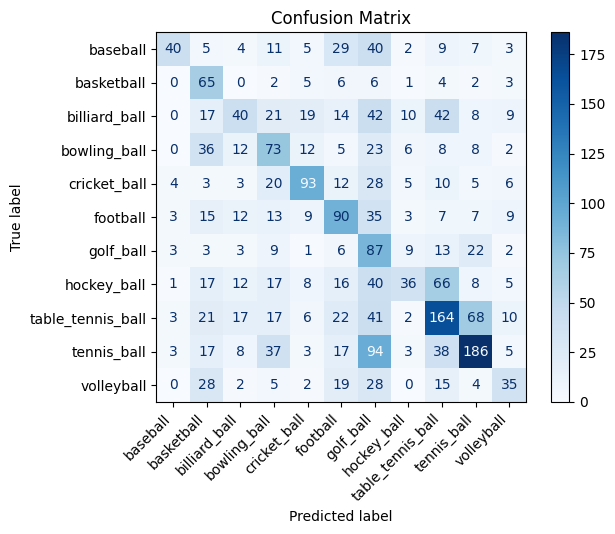

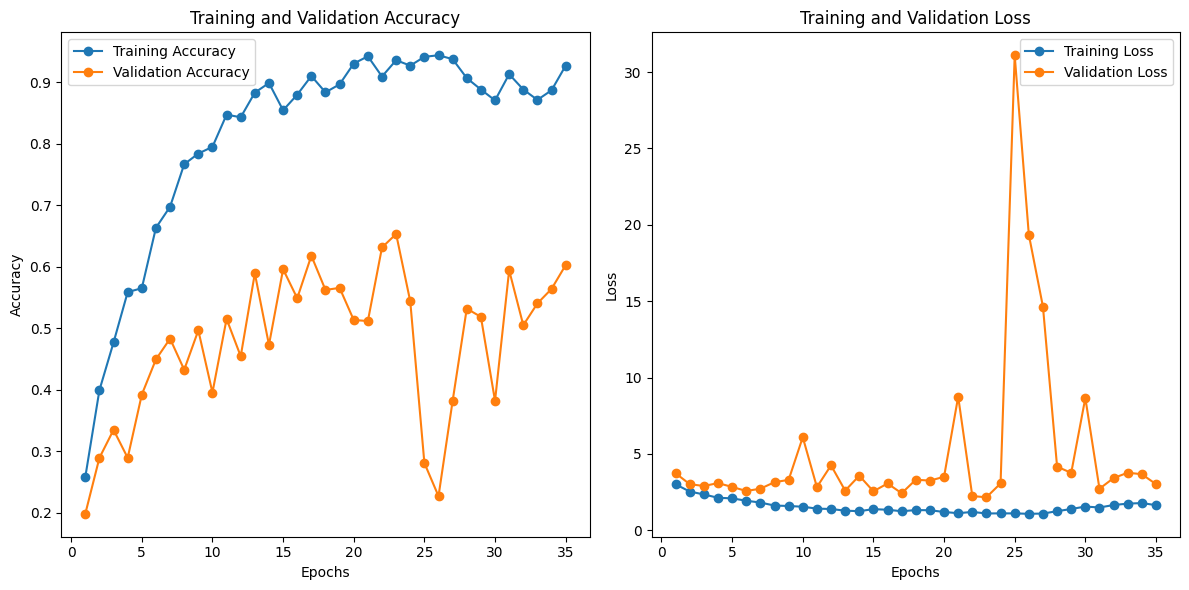

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.saving import load_model


def evaluate_model(model: keras.Sequential, x_test: np.ndarray, y_test: np.ndarray) -> Tuple[float, float]:
    # Add channel dimension if necessary
    # x_test = np.array(x_test).astype("float32") / 255.0
    x_test = np.expand_dims(x_test, axis=-1)

    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predict the labels for the test data
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Generate classification report
    report = classification_report(y_true, y_pred, digits=4)
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=45, ha='right')
    plt.title("Confusion Matrix")
    plt.show()

    # Training and validation loss/accuracy plots
    history_dict = history.history  # Assuming `history` is the training history object
    epochRange = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(12, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochRange, history_dict['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochRange, history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochRange, history_dict['loss'], label='Training Loss', marker='o')
    plt.plot(epochRange, history_dict['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


loaded_model = load_model("ball_cnn.keras")
evaluate_model(loaded_model, x_test, y_test)
